# Usage: SIR-derived models
Here, we will create an example dataset with theoretical values of SIR-derived model. Then, we will perform scenario analysis with it.

## Preparation

In [1]:
from pprint import pprint

In [2]:
import covsirphy as cs
cs.__version__

'2.17.0'

In [3]:
# Instance to save population values
population_data = cs.PopulationData(filename=None)
population_data.cleaned()

,ISO3,Country,Province,Date,Population


## Create example dataset with theoretical values
We will use `ExampleData` class to produce theoretical values. Model descriptions (`SIR` class etc.) have preset of parameter values. Then, $\tau$ (coeficient for non-dimensionalization) will be set as $1440\ \mathrm{[min]}$. The first date of records will be 01Jan2020 as an example.

In [4]:
# Set tau value and start date of records
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


`ExampleData` class is a child class of `JHUData`. This means that we can use the example data in scenario analysis. Example codes will be shown in "Scenario analysis with theoretical data" subsection.

In [5]:
issubclass(cs.ExampleData, cs.JHUData)

True

In [6]:
isinstance(example_data, cs.JHUData)

True

## SIR model
Let's start with simle SIR model. Details of models are explained in [Kaggle: COVID-19 data with SIR model](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#SIR-to-SIR-F).
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible (= Population - Confirmed)  
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)  
* $\mathrm{R}$: Recovered or Fatal (= Recovered + Fatal)  

Parameters:  

* $\beta$: Effective contact rate $\mathrm{[1/min]}$  
* $\gamma$: Recovery (+ Mortality) rate $\mathrm{[1/min]}$  

Note:  
Though R in SIR model is "Recovered and have immunity", we defines "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

In [7]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


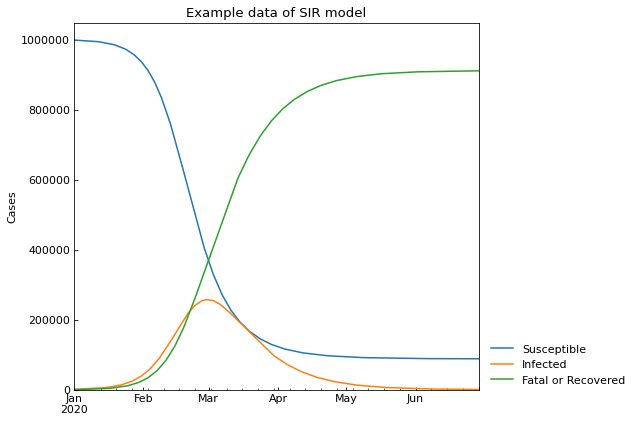

In [8]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible (= Population - Confirmed)  
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)  
* $\mathrm{R}$: Recovered  
* $\mathrm{D}$: Fatal  

Parameters:  

* $\alpha$: Mortality rate $\mathrm{[1/min]}$  
* $\beta$: Effective contact rate $\mathrm{[1/min]}$  
* $\gamma$: Recovery rate $\mathrm{[1/min]}$  

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}


In [9]:
# Model name
print(cs.SIRD.NAME)
# Example parameter values
pprint(cs.SIRD.EXAMPLE, compact=True)

SIR-D
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


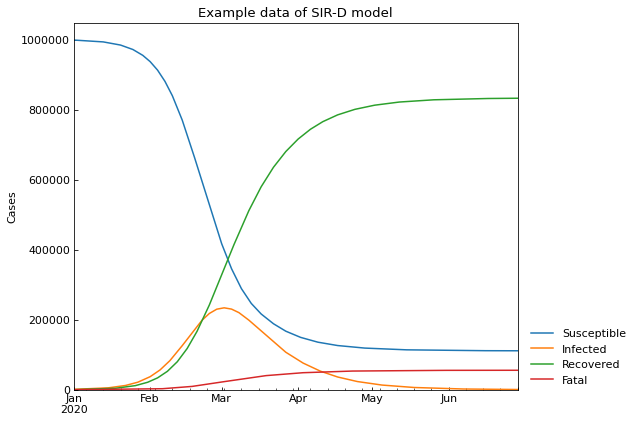

In [10]:
model = cs.SIRD
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SIR-F model
In the initial phase of COVID-19 outbreak, many cases were confirmed after they died. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model. When $\alpha_{1}=0$, SIR-F model will be the same as SIR-D model.
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible (= Population - Confirmed)  
* $\mathrm{S}^\ast$: Confirmed and un-categorized  
* $\mathrm{I}$: Confirmed and categorized as Infected  
* $\mathrm{R}$: Confirmed and categorized as Recovered  
* $\mathrm{F}$: Confirmed and categorzied as Fatal  

Parameters:  

* $\alpha_1$: Direct fatality probability of $\mathrm{S}^\ast$ (non-dimensional) 
* $\alpha_2$: Mortality rate of Infected cases $\mathrm{[1/min]}$  
* $\beta$: Effective contact rate $\mathrm{[1/min]}$  
* $\gamma$: Recovery rate $\mathrm{[1/min]}$  

Notes on $\mathrm{S}^\ast$ variable:  
$\mathrm{S}^\ast$ describes the cases who are actually carriers of the disease without anyone (including themselves) knowing about it, who either die and they are confirmed positive after death, while some others are moved to infected after being confirmed.

In JHU-style dataset, we know the number of cases who were confirmed with COVID-19, but we do not know the number of died cases who died without COVID-19.
Essentially $\mathrm{S}^\ast$ serves as an auxiliary compartment in SIR-F model to separate the two death situations and insert a probability factor of {$\alpha_1$, $1 - \alpha_1$}.

Notes on the difference of SIR-D and SIR-F model:  
$\alpha_1$ is small at this time because performance of PCR tests was improved, but we can use SIR-F model rather than SIR-D model as an enhanced model even now becase $\alpha_1$ can be 0 in the ODE model.

### Non-dimensional SIR-F model
Set $(S, I, R, F) = N \times (x, y, z, w)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}


In [11]:
# Model name
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


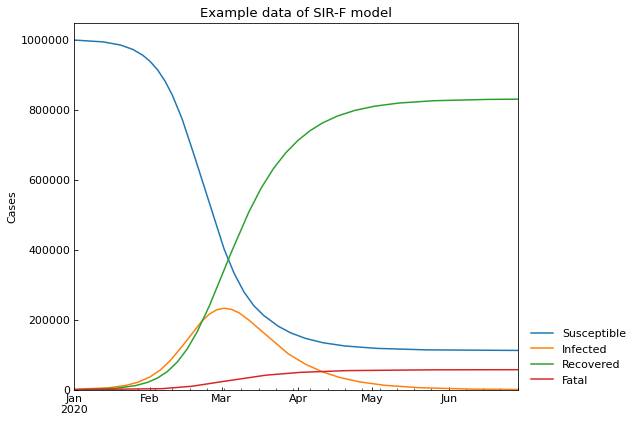

In [12]:
model = cs.SIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SEWIR-F model (SIR-F with exposed/waiting cases)
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S$\overset{\beta I}{\longrightarrow}$S$^\ast$ as follows because W also has infectivity.
\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

Variables:  

* $\mathrm{S}$: Susceptible  
* $\mathrm{E}$: <u>Exposed and in latent period (without infectivity)</u>  
* $\mathrm{W}$: <u>Waiting for confirmaion fiagnosis (with infectivity)</u>  
* $\mathrm{S}^\ast$: Confirmed and un-categorized  
* $\mathrm{I}$: Confirmed and categorized as Infected  
* $\mathrm{R}$: Confirmed and categorized as Recovered  
* $\mathrm{F}$: Confirmed and categorzied as Fatal  

Parameters:  

* $\alpha_1$: Direct fatality probability of $\mathrm{S}^\ast$ (non-dimensional) 
* $\alpha_2$: Mortality rate of Infected cases $\mathrm{[1/min]}$  
* $\beta_1$: <u>Exposure rate (the nymber of encounter with the virus in a minute)</u> $\mathrm{[1/min]}$  
* $\beta_2$: <u>Inverse of latent period</u> $\mathrm{[1/min]}$  
* $\beta_3$: <u>Inverse of waiting time for confirmation</u> $\mathrm{[1/min]}$  
* $\gamma$: Recovery rate $\mathrm{[1/min]}$ 

## Non-dimensional SEWIR-F model
Set $(S, E, W, I, R, F) = N \times (x_1, x_2, x_3, y, z, w)$, $(T, \alpha_1) = (\tau t, \theta)$ and $(\alpha_2, \beta_i, \gamma) = \tau^{-1} \times (\kappa, \rho_i, \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x_1}{\mathrm{d}t}= - \rho_1 x_1 (x_3 + y)  \\
& \frac{\mathrm{d}x_2}{\mathrm{d}t}= \rho_1 x_1 (x_3 + y) - \rho_2 x_2  \\
& \frac{\mathrm{d}x_3}{\mathrm{d}t}= \rho_2 x_2 - \rho_3 x_3  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= (1-\theta) \rho_3 x_3 - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \theta \rho_3 x_3 + \kappa y  \\
\end{align*}

Note:  
**We cannot use SEWIR-F model for parameter estimation because we do not have records of Exposed and Waiting. Please use SIR-F model with covsirphy.SIRF class.**

In [13]:
# Model name
print(cs.SEWIRF.NAME)
# Example parameter values
pprint(cs.SEWIRF.EXAMPLE, compact=True)

SEWIR-F
{'param_dict': {'kappa': 0.005,
                'rho1': 0.2,
                'rho2': 0.167,
                'rho3': 0.167,
                'sigma': 0.075,
                'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Exposed': 3000,
             'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 994000,
             'Waiting': 0.002}}


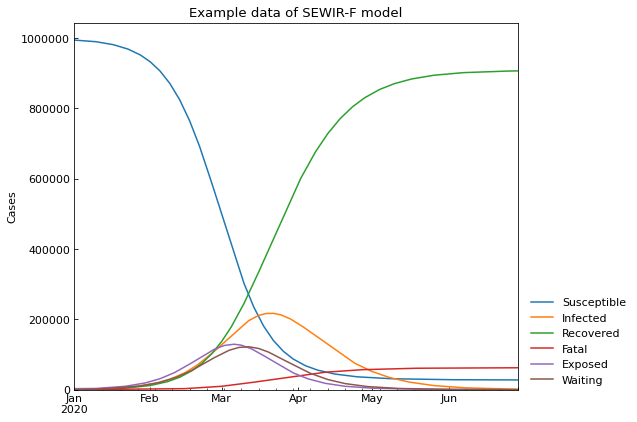

In [14]:
model = cs.SEWIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(df.set_index("Date"), title=f"Example data of {model.NAME} model", y_integer=True)

## SIR-F model with vaccination
In the previous version, we defined SIR-FV model with $\omega$ (vaccination rate) and
$$
\frac{\mathrm{d}S}{\mathrm{d}T}= - \beta S I - \omega N  \\
$$

However, **SIR-FV model was removed because vaccinated persons may move to the other compartments. Please use SIR-F model and adjust parameter values of SIR-F model, considering the impact of vaccinations on infectivity, effectivity and safety.**

## SIR-S model
Re-infection (Recovered -> Susceptble) is sometimes reported and we can consider SIR-S (SIR-FS) model. However, this is not impremented at this time because we do not have data regarding re-infection. SIR-F model could be the final model in our data-driven approach at this time.  

Re-infection changes the parameter values of SIR-F model. There are two patterns.

1. If re-infected case is counted as a new confirmed case and removed from "Recovered" compartment, $\sigma$ will be decreased.
2. If re-infected case is counted as a new confirmed case and NOT removed from "Recovered" compartment, $\rho$ will be increased because "Susceptible" will be decreased.

## Scenario analysis with theoretical data
Because `ExampleData` class is a subclass of `JHUData`, we can perform scenario analysis with example datasets easily. Here, we will use the following scenarios. For explanation, $\tau=1440$, the start date is 01Jan2020, population is 1,000,000 and country name is "Theoretical". **Their scenarios are not based on actual data.**

| name | 01Jan2020 - 31Jan2020 | 01Feb2020 - 31Dec2020 |
|:---:|:---:|:---|
| Main | SIR-F | SIR-F|
| Lockdown | SIR-F | SIR-F with 50% of $\rho$ |
| Medicine | SIR-F | SIR-F with 50% of $\kappa$ and 200% of $\sigma$ |
| Vaccine | SIR-F | SIR-F with 80% of $\rho$, 60% of $\kappa$ and 120% of $\sigma$|

In [15]:
# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
preset_dict

{'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}

In [16]:
area = {"country": "Theoretical"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)
# Register population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
population_data.value(**area)

1000000

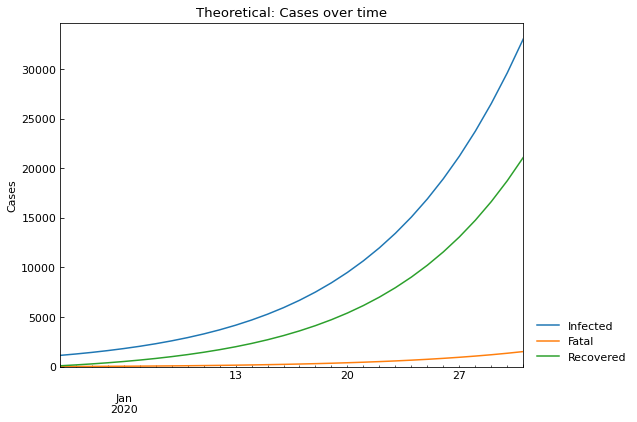

,Date,Infected,Fatal,Recovered
0,2020-01-02,1127,6,80
1,2020-01-03,1270,12,169
2,2020-01-04,1430,19,271
3,2020-01-05,1612,28,385
4,2020-01-06,1816,37,513


,Date,Infected,Fatal,Recovered
25,2020-01-27,21210,940,13068
26,2020-01-28,23730,1061,14753
27,2020-01-29,26524,1196,16637
28,2020-01-30,29616,1347,18741
29,2020-01-31,33030,1515,21088


In [17]:
# Show records with Scenario class
snl = cs.Scenario(example_data, population_data, tau=1440, **area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())
# From version 2.17.0, we will prefer to use
# snl = cs.Scenario(**area)
# snl.register(example_data, population_data)

Note:  
Record on 01Jan2020 was removed because the number of recovered cases is 0 and this sometimes causes error in estimation.

In [18]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
0th,Past,02Jan2020,31Jan2020,1000000,SIR-F,2.5,0.002,0.005,0.2,0.075,1440,0.002,200,5,13


In [19]:
# Add main scenario
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
snl.clear(name="Lockdown")
rho_lock = snl.get("rho", phase="0th") * 0.5
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_lock)
# Add medicine scenario
snl.clear(name="Medicine")
kappa_med = snl.get("kappa", phase="0th") * 0.5
sigma_med = snl.get("sigma", phase="0th") * 2
snl.add(end_date="31Dec2020", name="Medicine", kappa=kappa_med, sigma=sigma_med)
# Add vaccine scenario
snl.clear(name="Vaccine")
rho_vac = snl.get("rho", phase="0th") * 0.8
kappa_vac = snl.get("kappa", phase="0th") * 0.6
sigma_vac = snl.get("sigma", phase="0th") * 1.2
snl.add(end_date="31Dec2020", name="Vaccine",  rho=rho_vac, kappa=kappa_vac, sigma=sigma_vac)
# Summarize
snl.summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.25  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.31  0.002   
Vaccine  0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.72  0.002   

                 kappa   rho  sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                          
Main     0th    0.0050  0.20  0.075  1440       0.002             200   
         1st    0.0050  0.20  0.075  1440       0.002             200   
Lockdown 0th    0.0050  0.20  0.075  1440       0.002             200   
         1st    0.0050  0.10  0.075  1440       0.002             200   
Medicine 0th    0.0050  0.20  0.075  1440       0.002             200   
         1st    0.0025  0.20  0.150  1440       0.002             400   
Vaccine  0th    0.0050  0.20  0.075  1440       0.002             200   
         1st    0.0030  0.16  0.090  1440       0.002             333   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th               5             13  
         1st               5             13  
Lockdown 0th               5             13  
         1st              10             13  
Medicine 0th               5             13  
         1st               5              6  
Vaccine  0th               5             13  
         1st               6             11

### Compare the scenarios

In [20]:
# Describe the scenarios
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021,1st_Rt
Main,232568,02Mar2020,891643,0,57398,2.50
Lockdown,47079,08Mar2020,443712,106,28555,1.25
Medicine,53837,22Feb2020,491125,0,10181,1.31
Vaccine,114877,09Mar2020,710872,0,25070,1.72


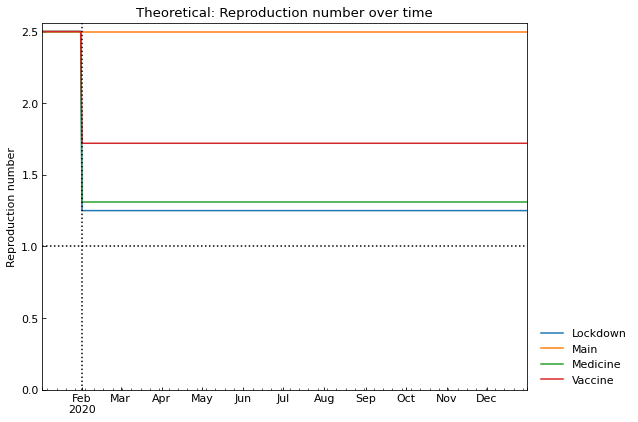

In [21]:
_ = snl.history(target="Rt")

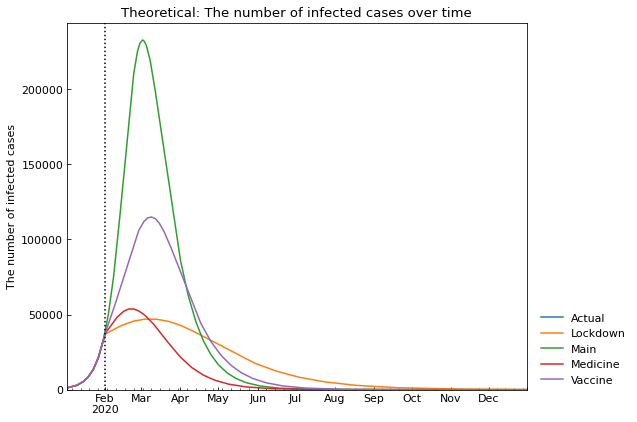

In [22]:
_ = snl.history(target="Infected")

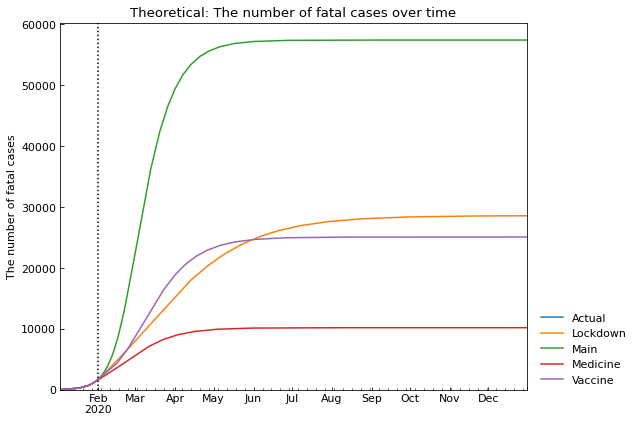

In [23]:
_ = snl.history(target="Fatal")

### Simulation of each scenario

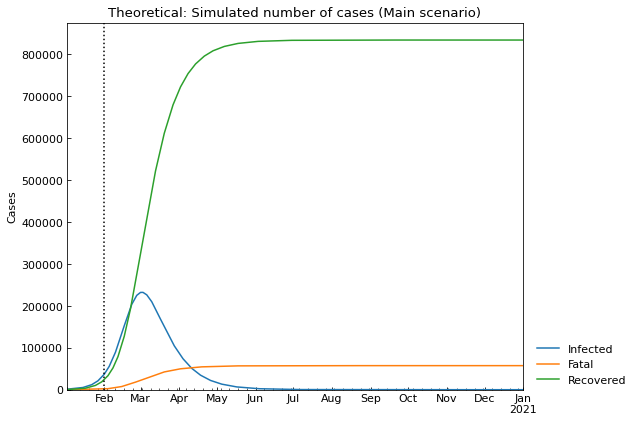

In [24]:
_ = snl.simulate(name="Main")

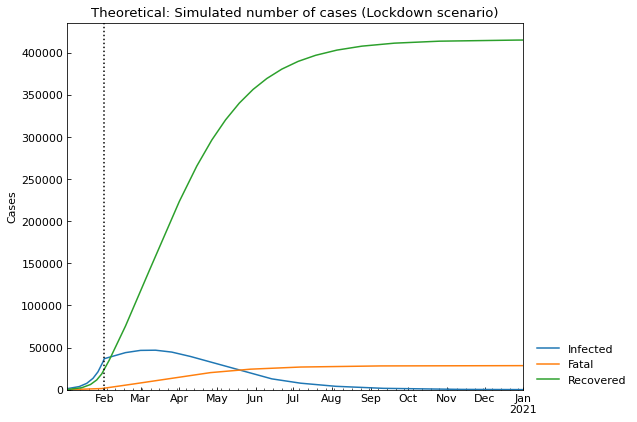

In [25]:
_ = snl.simulate(name="Lockdown")

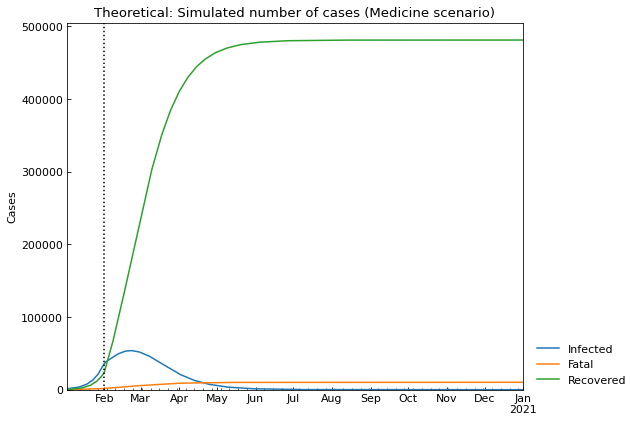

In [26]:
_ = snl.simulate(name="Medicine")

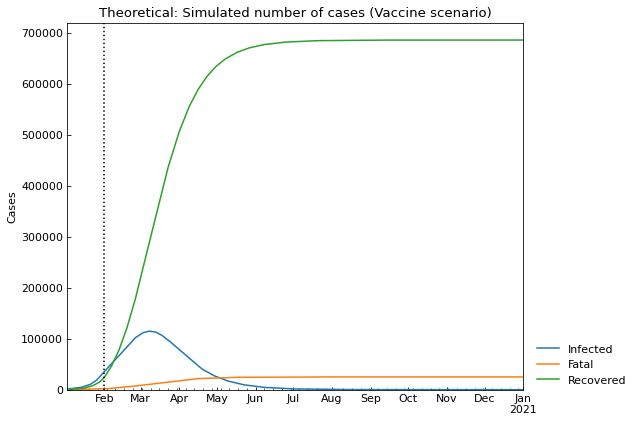

In [27]:
_ = snl.simulate(name="Vaccine")